# Home Credit Ad Hoc Analysis

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import iqr, randint, uniform
import xgboost as xgb
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import Imputer, StandardScaler, RobustScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
from skopt import gp_minimize
from skopt.plots import plot_convergence, plot_objective
from IPython.display import display
import pickle
import gc

pd.options.display.max_columns = None
gc.enable()
np.random.seed(0)

path = "/Users/danielsaxton/home_credit_default_risk/"

In [33]:
application_test = pd.read_csv(path + "application_test.csv")

In [ ]:
application_train = pd.read_csv(path + "application_train.csv")

In [4]:
bureau_balance = pd.read_csv(path + "bureau_balance.csv")
bureau = pd.read_csv(path + "bureau.csv")
credit_card = pd.read_csv(path + "credit_card_balance.csv")
installments = pd.read_csv(path + "installments_payments.csv")
pos_cash = pd.read_csv(path + "POS_CASH_balance.csv")
previous_application = pd.read_csv(path + "previous_application.csv")

In [84]:
bureau_agg = pd.read_csv(path + "bureau_agg.csv")

In [3]:
credit_card_agg = pd.read_csv(path + "credit_card_agg.csv")

In [ ]:
df = pd.read_csv(path + "preprocessed_train.csv")

In [92]:
n = 800

(installments.
     join(application_train.loc[application_train["TARGET"] == 1, ["SK_ID_CURR", "TARGET"]], how="inner", on="SK_ID_CURR", rsuffix="_app").
     sort_values(["SK_ID_CURR", "SK_ID_PREV", "DAYS_INSTALMENT"]).
     where(lambda x: x["DAYS_INSTALMENT"] >= -360).
     dropna(how="all").
     head(n).
     tail(20).
     pipe(display))

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,SK_ID_CURR_app,TARGET
2398375,1156837.0,100755.0,1.0,19.0,-43.0,-52.0,11800.935,11800.935,216979.0,1.0
2650128,1156837.0,100755.0,1.0,20.0,-13.0,-25.0,11800.935,11800.935,216979.0,1.0
2596071,1464904.0,100755.0,1.0,8.0,-341.0,-311.0,5823.585,5823.585,216979.0,1.0
8191,1464904.0,100755.0,3.0,102.0,-325.0,-311.0,291.195,291.195,216979.0,1.0
2627493,1464904.0,100755.0,4.0,103.0,-320.0,-311.0,291.195,291.195,216979.0,1.0
239479,1464904.0,100755.0,5.0,104.0,-315.0,-311.0,291.195,291.195,216979.0,1.0
1663495,1464904.0,100755.0,1.0,9.0,-311.0,-311.0,5823.585,5823.585,216979.0,1.0
2274296,1464904.0,100755.0,1.0,10.0,-281.0,-289.0,5823.585,5823.585,216979.0,1.0
1952810,1464904.0,100755.0,1.0,11.0,-251.0,-256.0,5823.585,5823.585,216979.0,1.0
2718252,1464904.0,100755.0,1.0,12.0,-221.0,-240.0,5818.365,5818.365,216979.0,1.0


In [93]:
(installments.
     join(application_train.loc[application_train["TARGET"] == 0, ["SK_ID_CURR", "TARGET"]], how="inner", on="SK_ID_CURR", rsuffix="_app").
     sort_values(["SK_ID_CURR", "SK_ID_PREV", "DAYS_INSTALMENT"]).
     where(lambda x: x["DAYS_INSTALMENT"] >= -360).
     dropna(how="all").
     head(n).
     tail(20).
     pipe(display))

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,SK_ID_CURR_app,TARGET
2660008,1128717.0,100107.0,0.0,9.0,-183.0,-191.0,2250.000,2250.000,216214.0,0.0
3569187,1128717.0,100107.0,0.0,11.0,-180.0,-180.0,79.065,79.065,216214.0,0.0
871412,1128717.0,100107.0,0.0,12.0,-174.0,-174.0,18000.000,18000.000,216214.0,0.0
2663697,1128717.0,100107.0,0.0,14.0,-156.0,-156.0,1244.925,1244.925,216214.0,0.0
421231,1128717.0,100107.0,0.0,13.0,-152.0,-156.0,3255.075,3255.075,216214.0,0.0
1047859,1128717.0,100107.0,0.0,15.0,-147.0,-147.0,1013.085,1013.085,216214.0,0.0
56138,1128717.0,100107.0,0.0,16.0,-142.0,-142.0,5850.000,5850.000,216214.0,0.0
2990877,1128717.0,100107.0,0.0,18.0,-128.0,-128.0,11442.060,11442.060,216214.0,0.0
845368,1128717.0,100107.0,0.0,17.0,-122.0,-128.0,5657.940,5657.940,216214.0,0.0
1206115,1128717.0,100107.0,0.0,19.0,-113.0,-113.0,1140.930,1140.930,216214.0,0.0


In [4]:
credit_card_agg.head()

,SK_ID_CURR,AVG_AMT_DRAWINGS_CURRENT,AVG_AMT_PAYMENT_CURRENT_DIV_AMT_INST_MIN_REGULARITY,AVG_BALANCE,AVG_BALANCE_6M,AVG_BALANCE_WEIGHTED,AVG_CNT_DRAWINGS_CURRENT,AVG_UTILIZATION,AVG_UTILIZATION_6M,AVG_UTILIZATION_WEIGHTED,DIFF_AVG_BALANCE_6M_12M,MAX_AMT_DRAWINGS_CURRENT,MAX_AMT_DRAWINGS_CURRENT_12M,MAX_AMT_DRAWINGS_CURRENT_6M,MAX_AMT_INST_MIN_REGULARITY_12M,MAX_AMT_INST_MIN_REGULARITY_6M,MAX_AMT_PAYMENT_CURRENT_DIV_AMT_INST_MIN_REGULARITY,MAX_BALANCE,MAX_BALANCE_WEIGHTED,MAX_CNT_DRAWINGS_CURRENT,MAX_CNT_DRAWINGS_POS_CURRENT_12M,MAX_CNT_DRAWINGS_POS_CURRENT_6M,MAX_CREDIT_CARD_SK_DPD_12M,MAX_CREDIT_CARD_SK_DPD_6M,MAX_DPD_DEF_WEIGHTED,MAX_DPD_WEIGHTED,MAX_MONTHS_BALANCE,MAX_UTILIZATION,MAX_UTILIZATION_WEIGHTED,MIN_AMT_PAYMENT_CURRENT_DIV_AMT_INST_MIN_REGULARITY,MIN_MONTHS_BALANCE,RANGE_MONTHS_BALANCE,SUM_AMT_DRAWINGS_CURRENT,SUM_BALANCE,SUM_BALANCE_WEIGHTED,SUM_CNT_DRAWINGS_CURRENT
0,100006,0.000000,NaN,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.00,0.000000,0.0,NaN,NaN,0.0,0.0,0.000000,0.000000,6.0,0.00000,0.000000,NaN,1.0,5.0,0.0,0.000,0.000000,0.0
1,100011,2432.432432,inf,54482.111149,0.0,891.528045,0.054054,0.302678,0.0,0.004953,0.0,180000.0,0.0,0.0,0.0,0.0,inf,189000.00,2520.000000,4.0,0.0,0.0,0.0,0.0,0.000000,0.000000,75.0,1.05000,0.014000,1.0,2.0,73.0,180000.0,4031676.225,65973.075311,4.0
2,100013,5953.125000,inf,18159.919219,0.0,230.066978,0.239583,0.115301,0.0,0.001461,0.0,157500.0,0.0,0.0,0.0,0.0,inf,161420.22,1944.407308,7.0,0.0,0.0,0.0,0.0,0.014493,0.014493,96.0,1.02489,0.012345,0.0,1.0,95.0,571500.0,1743352.245,22086.429911,23.0
3,100021,0.000000,NaN,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.00,0.000000,0.0,NaN,NaN,0.0,0.0,0.000000,0.000000,18.0,0.00000,0.000000,NaN,2.0,16.0,0.0,0.000,0.000000,0.0
4,100023,0.000000,NaN,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.00,0.000000,0.0,NaN,NaN,0.0,0.0,0.000000,0.000000,11.0,0.00000,0.000000,NaN,4.0,7.0,0.0,0.000,0.000000,0.0


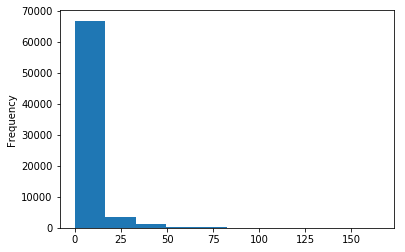

In [6]:
credit_card_agg["MAX_CNT_DRAWINGS_POS_CURRENT_6M"].plot(kind="hist")

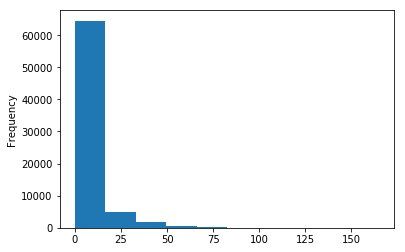

In [7]:
credit_card_agg["MAX_CNT_DRAWINGS_POS_CURRENT_12M"].plot(kind="hist")

In [11]:
credit_card_agg["MAX_CREDIT_CARD_SK_DPD_12M"].std()

130.39352354498595